In [64]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

df = pd.read_excel('/Users/aarsh/Desktop/CGVI/Thesis/Data/360VOT_attribute.xlsx', engine = 'openpyxl')
df.head()


,sequence,target,length,IV(illumination variation),BC(background clutter),DEF(deformable target),MB(motion blur),CM(camera motion),ROT(rotation),POC(partial occlusion),...,HR(high resolution),Unnamed: 16,SA(stitching artifact),CB(cross border),FMS(fast motion on the sphere),LFoV(large FoV),LV(latitude variant),HL(high latitude),LD(large distortion),Unnamed: 24
0,1.0,basket,251.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN
1,2.0,bike,854.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN
2,3.0,bird,740.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,...,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN
3,4.0,bird,690.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN
4,5.0,boat,483.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN


In [65]:
df.columns

Index(['sequence', 'target', 'length', 'IV(illumination variation)',
       'BC(background clutter)', 'DEF(deformable target)', 'MB(motion blur)',
       'CM(camera motion)', 'ROT(rotation)', 'POC(partial occlusion)',
       'FOC(full occlusion)', 'ARC(aspect ratio change)',
       'SV(scale variation)', 'FM(fast motion)', 'LR(low resolution)',
       'HR(high resolution)', 'Unnamed: 16', 'SA(stitching artifact)',
       'CB(cross border)', 'FMS(fast motion on the sphere)', 'LFoV(large FoV)',
       'LV(latitude variant)', 'HL(high latitude)', 'LD(large distortion)',
       'Unnamed: 24'],
      dtype='object')

In [4]:
occlusion_df = df[(df['POC(partial occlusion)'] == 1.0)  & (df['FOC(full occlusion)'] == 1.0)]
occlusion_df

,sequence,target,length,IV(illumination variation),BC(background clutter),DEF(deformable target),MB(motion blur),CM(camera motion),ROT(rotation),POC(partial occlusion),...,HR(high resolution),Unnamed: 16,SA(stitching artifact),CB(cross border),FMS(fast motion on the sphere),LFoV(large FoV),LV(latitude variant),HL(high latitude),LD(large distortion),Unnamed: 24
4,5.0,boat,483.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN
5,6.0,boat,931.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
6,7.0,boat,661.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
7,8.0,boat,1457.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
8,9.0,boat,825.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,112.0,surfer,651.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,113.0,surfer,310.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN
113,114.0,tire,604.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
116,117.0,wing outfit,664.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [66]:
CB_LFOV = df[(df['CB(cross border)'] == 1.0) & (df['LFoV(large FoV)'] == 1.0) & (df['CM(camera motion)'] == 1.0)]
CB_LFOV.head()

,sequence,target,length,IV(illumination variation),BC(background clutter),DEF(deformable target),MB(motion blur),CM(camera motion),ROT(rotation),POC(partial occlusion),...,HR(high resolution),Unnamed: 16,SA(stitching artifact),CB(cross border),FMS(fast motion on the sphere),LFoV(large FoV),LV(latitude variant),HL(high latitude),LD(large distortion),Unnamed: 24
15,16.0,building,2400.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,...,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN
26,27.0,car,328.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,...,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN
49,50.0,fly,480.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
56,57.0,horse,501.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN
109,110.0,skydiver,470.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [63]:
FMS_df = df[df['FMS(fast motion on the sphere)'] == 1.0]
FMS_df.head(10)

,sequence,target,length,IV(illumination variation),BC(background clutter),DEF(deformable target),MB(motion blur),CM(camera motion),ROT(rotation),POC(partial occlusion),...,HR(high resolution),Unnamed: 16,SA(stitching artifact),CB(cross border),FMS(fast motion on the sphere),LFoV(large FoV),LV(latitude variant),HL(high latitude),LD(large distortion),Unnamed: 24
1,2.0,bike,854.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN
4,5.0,boat,483.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN
5,6.0,boat,931.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
6,7.0,boat,661.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
7,8.0,boat,1457.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
8,9.0,boat,825.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
9,10.0,boat,687.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN
10,11.0,boat,1081.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
11,12.0,building,1276.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN
12,13.0,building,651.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [72]:
LD_df = df[df['LD(large distortion)'] == 1.0]
LD_df.head(50)

,sequence,target,length,IV(illumination variation),BC(background clutter),DEF(deformable target),MB(motion blur),CM(camera motion),ROT(rotation),POC(partial occlusion),...,HR(high resolution),Unnamed: 16,SA(stitching artifact),CB(cross border),FMS(fast motion on the sphere),LFoV(large FoV),LV(latitude variant),HL(high latitude),LD(large distortion),Unnamed: 24
0,1.0,basket,251.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN
1,2.0,bike,854.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN
2,3.0,bird,740.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,...,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN
3,4.0,bird,690.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN
4,5.0,boat,483.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN
9,10.0,boat,687.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,...,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN
11,12.0,building,1276.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN
14,15.0,building,580.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN
15,16.0,building,2400.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,...,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN
16,17.0,building,740.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN


# Visualizing CNN Focus Using Grad-CAM in AiATrack's Local Search Regions

This script below uses Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize the areas of interest in the local search regions as processed by the CNN backbone of AiATrack. The goal is to understand where the network is focusing when analyzing these regions in the extended bounding field-of-view (BFoV) format.

## Key Components:

### 1. **Class Names Mapping:**
The script begins by defining a dictionary (`class_names`) that maps common object names to their corresponding ImageNet class indices. These classes include `'train'`, `'bus'`, `'car'`, `'cloud'`, `'plane'`, and `'house'`.

### 2. **Loading the Pre-trained Model:**
The script loads a pre-trained ResNet50 model from PyTorch's `models` library. The model is set to evaluation mode using `model.eval()`.

### 3. **Hooking Gradients and Activations:**
To create the Grad-CAM visualization, the script hooks into the gradients of the activations from the last convolutional layer (specifically `model.layer3[2].conv3`). Two functions, `save_gradient` and `save_activation`, are defined to capture the gradients and activations respectively. Hooks are then registered to the final convolutional layer to store these values during the forward and backward passes.

### 4. **Preprocessing the Input Image:**
The image to be analyzed is preprocessed using a series of transformations:
- **Resize:** The image is resized to 224x224 pixels.
- **Tensor Conversion:** The image is converted into a tensor.
- **Normalization:** The image is normalized using ImageNet's mean and standard deviation values.

### 5. **Generating Grad-CAM:**
The core function, `generate_gradcam`, performs the following steps:
- **Load and preprocess the input image** from the given path.
- **Forward pass**: The image is passed through the model to get the output predictions.
- **Backward pass**: Gradients are calculated with respect to the target class.
- **Pooling and Weighting**: The gradients are globally averaged, and these pooled gradients are used to weight the corresponding activations from the last convolutional layer.
- **Heatmap Generation**: A heatmap is created by averaging the weighted activations, applying ReLU, and normalizing the values between 0 and 1.
- **Superimposing Heatmap on the Original Image**: The heatmap is resized to match the input image dimensions and then superimposed on the original image to highlight the regions where the model is focusing.

### 6. **Visualization and Output:**
- The original image and the Grad-CAM heatmap are displayed side by side using `matplotlib` for visual comparison.

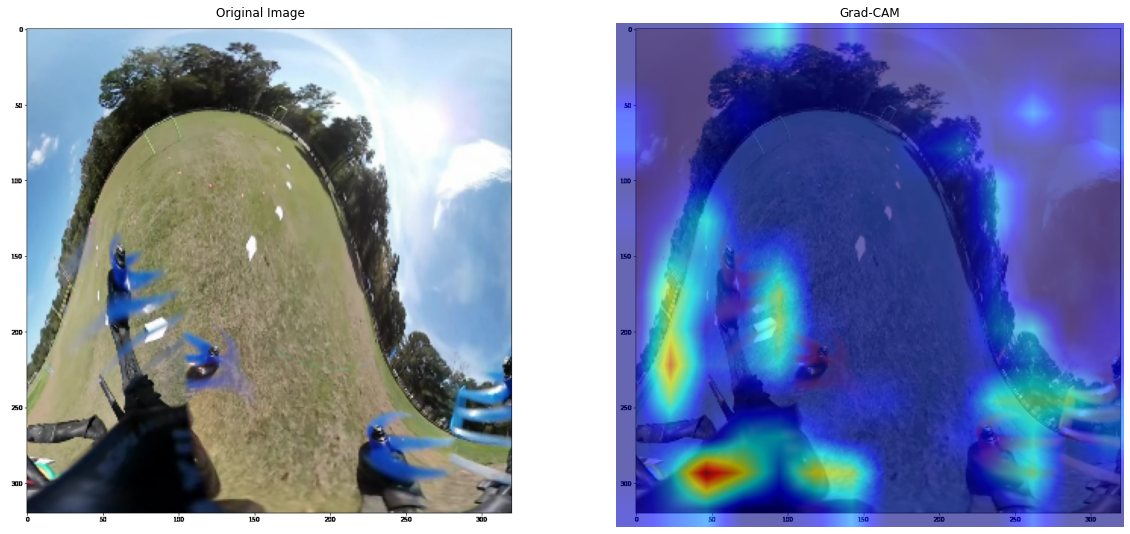

True

In [154]:
# Define the class names corresponding to the ImageNet classes
class_names = {
    'train': 466,
    'bus': 779,
    'car': 817,
    'cloud': 908,
    'plane': 404,
    'house': 497
}

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Hook the gradients of the activations of the last conv layer
gradients = None
activations = None

def save_gradient(grad):
    global gradients
    gradients = grad

def save_activation(module, input, output):
    global activations
    activations = output

# Get the last convolutional layer
final_conv_layer = model.layer3[2].conv3

# Register hooks to get gradients and activations
final_conv_layer.register_backward_hook(lambda module, grad_in, grad_out: save_gradient(grad_out[0]))
final_conv_layer.register_forward_hook(save_activation)

# Define the preprocess transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to generate Grad-CAM
def generate_gradcam(img_path, target_class):
    img = Image.open(img_path).convert('RGB')  # Convert image to RGB if it's not already
    img_tensor = preprocess(img).unsqueeze(0)

    # Forward pass
    outputs = model(img_tensor)

    # Backward pass
    model.zero_grad()
    class_idx = class_names[target_class]
    score = outputs[0, class_idx]
    score.backward()

    # Get the gradients of the output with respect to the parameters of the model
    gradients_np = gradients.data.numpy()
    
    # Get the activations of the last convolutional layer
    activations_np = activations.detach().numpy()

    # Global average pooling of the gradients
    pooled_gradients = np.mean(gradients_np, axis=(2, 3))

    # Weight the activations by the gradients
    for i in range(pooled_gradients.shape[1]):
        activations_np[0, i, :, :] *= pooled_gradients[0, i]

    # Average the weighted activations across all channels
    heatmap = np.mean(activations_np, axis=1).squeeze()

    # Apply ReLU to the heatmap (since Grad-CAM uses ReLU at the final step)
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap between 0 and 1
    heatmap /= np.max(heatmap)

    # Resize the heatmap to match the size of the input image
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap on the heatmap and make it lighter
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # heatmap = cv2.addWeighted(heatmap, 0.4, np.zeros_like(heatmap), 0.6, 0)  # Make the heatmap lighter

    # Superimpose the heatmap on the original image
    img = np.array(img)
    superimposed_img = cv2.addWeighted(heatmap, 0.6, img, 0.4, 0)

    return img, superimposed_img

# Example usage
img_path = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Experiments/grad_cam_vis/00029.png'
target_class = 'cloud'  # Choose from 'train', 'bus', 'car', 'cloud', 'plane', 'house'
original_image, gradcam_image = generate_gradcam(img_path, target_class)

# Display the original and Grad-CAM images side by side
plt.figure(figsize=(20, 10))  # Increase the figure size for better visibility

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_image[:, :, ::-1])
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

# Optionally save the output image
output_path = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Experiments/grad_cam_vis/layer3_vis/gradcam_output_0029.png'
cv2.imwrite(output_path, gradcam_image)


Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Co

In [155]:
# Python script to count the number of lines in a text file

def count_lines_in_file(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            num_lines = len(lines)
            print(f"The file '{file_path}' contains {num_lines} lines.")
    except FileNotFoundError:
        print(f"The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
file_path = '/Users/aarsh/Desktop/CGVI/Thesis/AiATrack/0035.txt'  # Replace with your file's path
count_lines_in_file(file_path)


The file '/Users/aarsh/Desktop/CGVI/Thesis/AiATrack/0035.txt' contains 600 lines.
